In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch

In [2]:
df_train = pd.read_csv("/kaggle/input/spam-data/train_spam.csv")
df_test = pd.read_csv("/kaggle/input/spam-data/test_spam.csv")

In [3]:
df_train[df_train['text'].str.contains('163')]

,text_type,text
19,ham,on september 1635465 kialllists url said os x ...
20,ham,hi i m building an rpm for the resin webserver...
24,ham,url jm url changed what removed added status n...
40,ham,on thu aug 1635465 1635465 at 1635465 1635465 ...
47,spam,adult club offers free membership instant acce...
...,...,...
16247,ham,on tue 1635465 1635465 1635465 at 1635465 1635...
16249,ham,any of your writing online anywhere would love...
16250,ham,url url date 1635465 1635465 1635465t1635465 1...
16254,ham,tim peters wrote i ve actually got a bunch of ...


In [4]:
(df_train.text_type == 'spam').sum()/len(df_train)

0.2954294139329156

немного не сбалансированы классы

приведем текст к нижнему регистру, оставим только символы латиницы

In [5]:
import re, string

def tokenize(text):
    text = text.lower()
    #chars = '[%s]+' % re.escape(string.punctuation)
    #text = re.sub(chars, ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    result = re.split(r'\s+', text)
#     result = result[:]
    return result

# Проверка вашей функции
tokenize("VK test assIgnmEnt")

['vk', 'test', 'assignment']

посчитаем статистики по словам, длину текстов

  0%|          | 0/16278 [00:00<?, ?it/s]

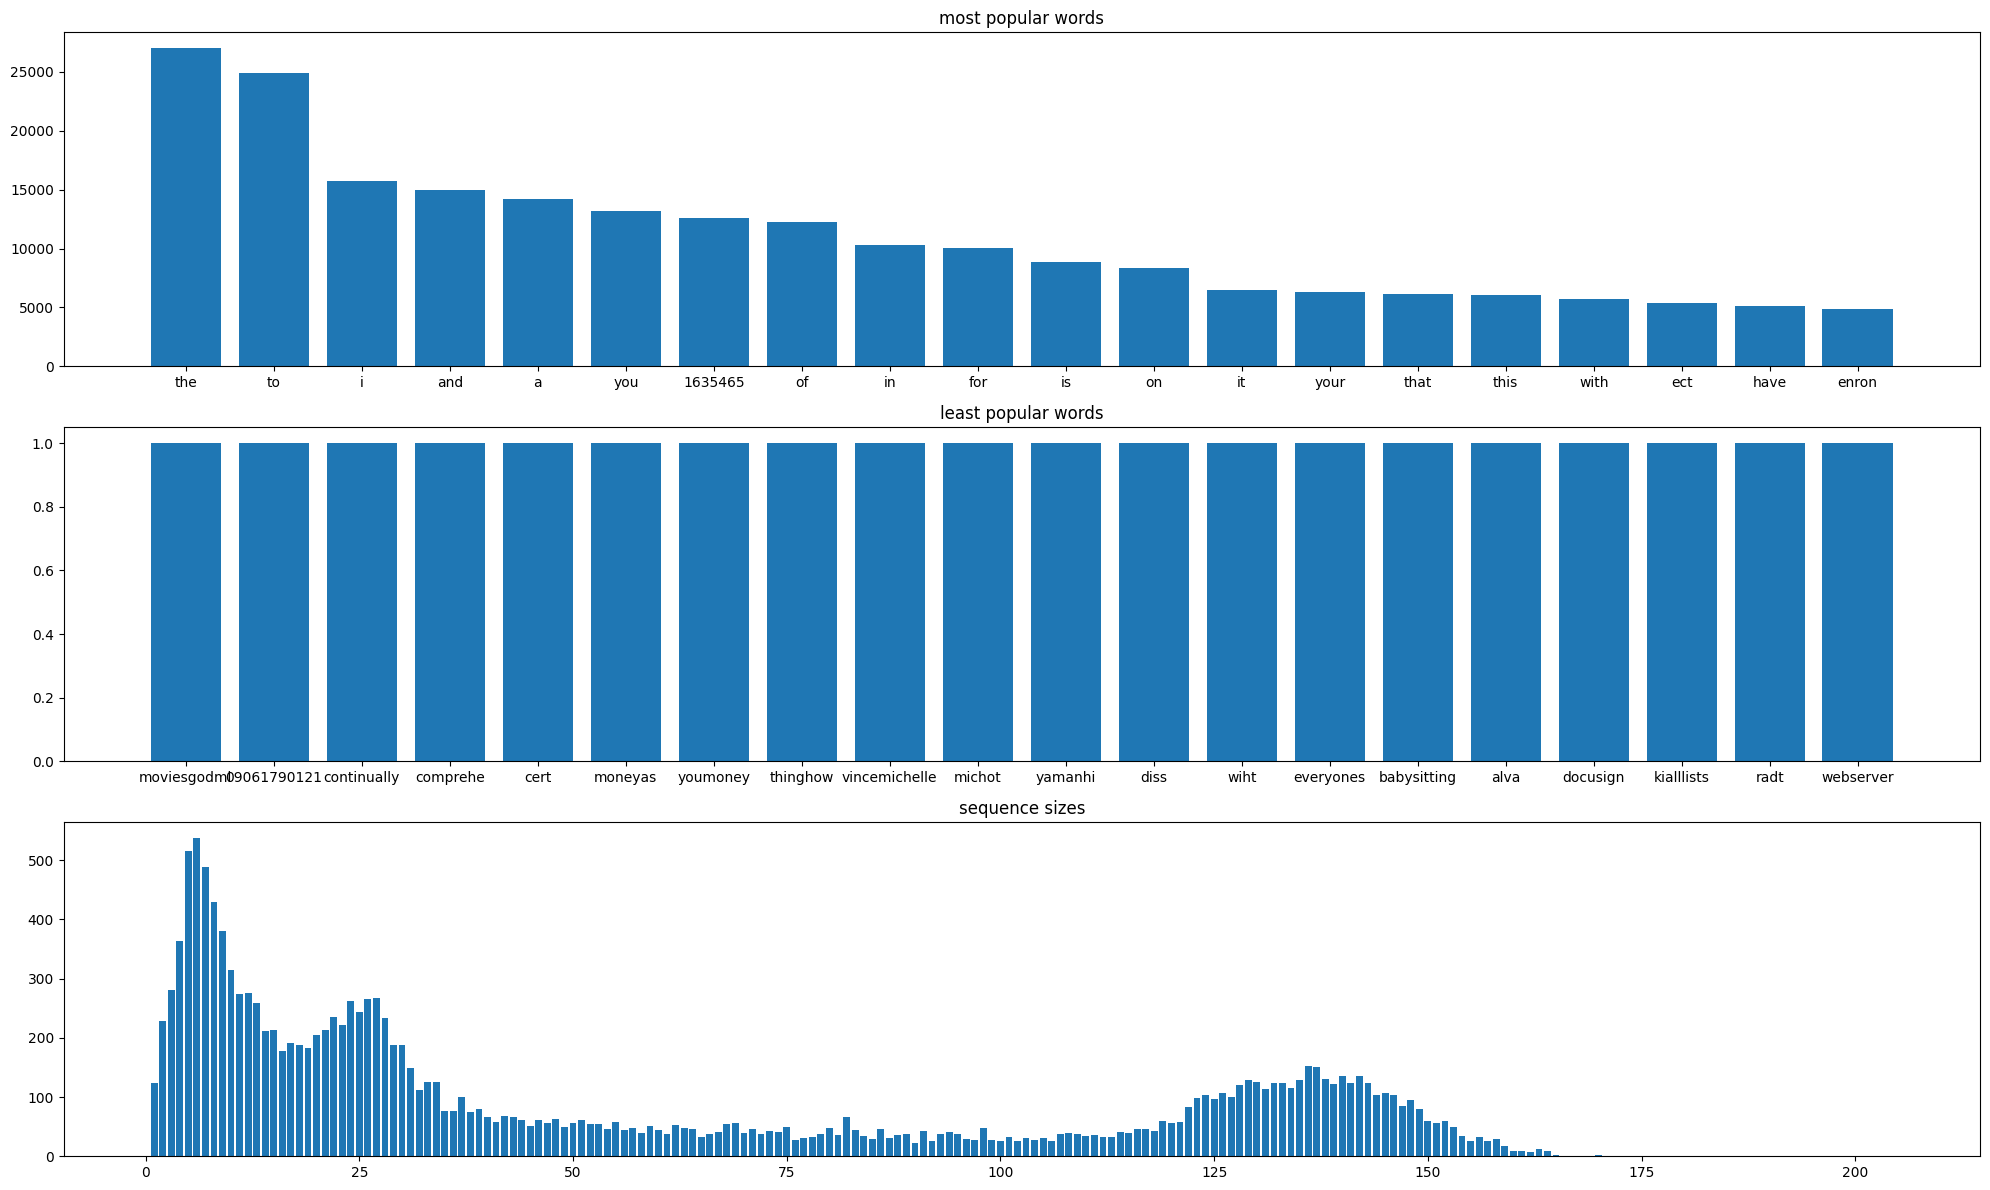

In [6]:
from tqdm.auto import trange
from collections import Counter

vocab_freq = Counter()

sizes = Counter()
for i in trange(len(df_train)):
    text = tokenize(df_train.text.iloc[i])
    sizes.update({len(text): 1})
    vocab_freq.update(Counter(text))

global_max_seq_len = np.max(list(sizes.keys()))

show_ = 20
fig, ax = plt.subplots(3, 1, figsize=(20, 12))

plt.subplot(312)
vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda item: item[1])}
plt.title('least popular words')
plt.bar(list(vocab_freq.keys())[:show_], list(vocab_freq.values())[:show_])

plt.subplot(311)
vocab_freq = {k: v for k, v in sorted(vocab_freq.items(), key=lambda item: item[1], reverse=True)}
plt.title('most popular words')
plt.bar(list(vocab_freq.keys())[:show_], list(vocab_freq.values())[:show_])

plt.subplot(313)
plt.title('sequence sizes')
plt.bar(list(sizes.keys()), list(sizes.values()))

fig.tight_layout()
plt.show()

In [7]:
MIN_FREQ = 3  # токены с частотой ниже этой константы заменим на <UNK>

tok_to_ind = {
    '<UNK>': 0,
    '<PAD>': 1,
}

ind_to_tok = {
    0: '<UNK>',
    1: '<PAD>',
}


for id, (word, freq) in enumerate(vocab_freq.items()):
    if freq >= MIN_FREQ:
        tok_to_ind[word] = id + 2
        ind_to_tok[id + 2] = word


assert len(tok_to_ind) == len(ind_to_tok)
vocab_size = len(tok_to_ind)
print(f"Resulting vocab size: {vocab_size} (out of {len(vocab_freq)} tokens overall, due to MIN_FREQ={MIN_FREQ})")

Resulting vocab size: 17603 (out of 53624 tokens overall, due to MIN_FREQ=3)


In [8]:
# Функция возвращает по тексту индексы токенов в тексте
def to_ids(text):
    toks = tokenize(text)
    ids = [-1] * len(toks)
    for i in range(len(toks)):
        if toks[i] in tok_to_ind:
            ids[i] = tok_to_ind[toks[i]]
        else:
            ids[i] = 0
    return ids

text = "This is test for function to_ids"
toks = tokenize(text)
ids = to_ids(text)

print(list(zip(toks, ids)))

[('this', 17), ('is', 12), ('test', 553), ('for', 11), ('function', 2368), ('to_ids', 0)]


In [9]:
df_train

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


In [10]:
import random
from torch.utils.data import Dataset, DataLoader

class SpamDataset(Dataset):
    """
    """
    def __init__(self, df, train=True):
        super(SpamDataset).__init__()
        
        self.train=train
        self.df = df

    def __getitem__(self, index):
        text = to_ids(self.df.text.iloc[index])
        label = self.df.text_type.iloc[index]
        return text, label

    def __len__(self):
        return self.df.__len__()

In [11]:
from sklearn.model_selection import train_test_split

df_train_new, df_val = train_test_split(df_train, shuffle=True, train_size=0.75)

In [12]:
df_train_new.text_type.describe()

count     12208
unique        2
top         ham
freq       8587
Name: text_type, dtype: object

In [13]:
ds_train = SpamDataset(
    df_train_new,
    train=True,
)

ds_val = SpamDataset(
    df_val,
    train=False,
    
)

In [14]:
ds_train[0][0]

[264, 117, 0, 0, 6994, 15, 238]

In [15]:
def collate_fn(batch):
    local_max = max([len(j[0])  for j in batch])

    text_batch = torch.zeros((len(batch), local_max), dtype=torch.int)
    label_batch = torch.zeros((len(batch)))

    for i, (text, label) in  enumerate(batch):
        text.extend([1]*(local_max-len(text)))


    for i, (text, label) in  enumerate(batch):
        text_batch[i,:] = torch.tensor(text)
        label_batch[i] = 1 if label == 'spam' else 0

    return text_batch, label_batch

In [16]:
def collate_fn_test(batch):
    local_max = max([len(j)  for j in batch])

    text_batch = torch.zeros((len(batch), local_max), dtype=torch.int)
#     label_batch = torch.zeros((len(batch)))

    for i, (text) in  enumerate(batch):
        text.extend([1]*(local_max-len(text)))

    return text_batch

In [17]:
batch_size = 64
num_workers = 0

dataloader_train = DataLoader(
    dataset=ds_train,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers,
)

dataloader_val = DataLoader(
    dataset=ds_val,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [18]:
for i in dataloader_train:
    print(i[0].shape)
    break

torch.Size([64, 164])


скачаем предобученные эмбеддинги представлений слов

In [19]:
#!:bash
!wget -O glove.zip https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip
# mirror https://nlp.stanford.edu/data/wordvecs/glove.840B.300d.zip

!unzip glove.zip

!ls -sh glove.*

--2024-05-03 17:49:09--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip
Resolving huggingface.co (huggingface.co)... 18.172.134.88, 18.172.134.4, 18.172.134.124, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.88|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/f47355dd5b267bd10f08671e513790690233c76a9ffd73aa915d78f894a8912e?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.840B.300d.zip%3B+filename%3D%22glove.840B.300d.zip%22%3B&response-content-type=application%2Fzip&Expires=1715017749&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcxNTAxNzc0OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9zdGFuZm9yZG5scC9nbG92ZS9mNDczNTVkZDViMjY3YmQxMGYwODY3MWU1MTM3OTA2OTAyMzNjNzZhOWZmZDczYWE5MTVkNzhmODk0YTg5MTJlP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=vC2D

инициализируем вектора эмбеддингов где знаем 

In [20]:
from tqdm import tqdm

np.random.seed(19)

def load_glove_weights(file_path, vocab, pad_token="<PAD>"):
    glove_weights = np.random.uniform(0, 1, (len(vocab), 300))
    mask_found = np.zeros(len(vocab), dtype=bool)

    with open(file_path, 'r') as f:
        for line in tqdm(f, total=2196018):
            line = line.split()
            token = ' '.join(line[:-300])
            embed = line[-300:]

            # Если нашли, то подменяем эмбеддинг из glove
            if token in vocab:
                ind = vocab[token]
                mask_found[ind] = True
#                 print(token)
                glove_weights[ind, :] = np.array(list(map(float, embed)), dtype=np.single)

    print(f"{mask_found.sum()} words from vocab of size {len(vocab)} loaded!")

    glove_weights[vocab[pad_token]] = np.zeros(300, dtype=np.single)
    return glove_weights, mask_found

glove_path = "./glove.840B.300d.txt"
glove_weights, mask_found = load_glove_weights(glove_path, tok_to_ind, "<PAD>")

100%|██████████| 2196018/2196018 [00:59<00:00, 36685.83it/s]

14343 words from vocab of size 17603 loaded!


Попробуем LSTM

In [21]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.embed_dim = 300
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=self.embed_dim, padding_idx=tok_to_ind['<PAD>'])
        self.embed.weight = nn.Parameter(
            torch.from_numpy(glove_weights).to(dtype=self.embed.weight.dtype),
            requires_grad=True,
        )
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size = 300, hidden_size = self.hidden_size, num_layers = num_layers, batch_first=True)
        self.to_logits = nn.Sequential(nn.Linear(hidden_size, 256),
                                         nn.ReLU(),
                                         nn.Linear(256, 1))


    def forward(self, text):
        hid_state = (torch.zeros(self.num_layers, text.shape[0], self.hidden_size).to(device), torch.zeros(self.num_layers, text.shape[0], self.hidden_size).to(device))
        inp_state = self.embed(text)
        features, hid_state = self.lstm(inp_state, hid_state)

        return nn.Sigmoid()(self.to_logits(hid_state[0][-1,:,:]))

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [23]:
def binary_accuracy(preds, y):
    preds= preds.squeeze()
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float()

    acc = correct.sum() / len(correct)
    return acc

In [24]:
from collections import defaultdict
from sklearn.metrics import roc_auc_score

def train(model, opt, loader, criterion):
    model.train()
    model.to(device)
    losses_tr = []
    for text_batch, label_batch in tqdm(loader):

        text_batch = text_batch.to(device)
        label_batch = label_batch.to(device)

        optimizer.zero_grad()

        pred = model(text_batch).to(device)

        loss = criterion(pred, label_batch[:,None])

        loss.backward()
        optimizer.step()
        losses_tr.append(loss.item())

    return model, optimizer, np.mean(losses_tr)


def val(model, loader, criterion, metric_names=None):
    model.eval()
    model.to(device)
    losses_val = []
    metrics = {'roc_auc': [], 'accuracy': []}
    with torch.no_grad():
        for text_batch, label_batch in tqdm(loader):

            text_batch = text_batch.to(device)
            label_batch = label_batch.to(device)
            
#             print(label_batch, 'target')
#             print(label_batch.shape, 'target.shape')
            pred = model(text_batch).to(device)
#             print(pred, 'predict proba')
            loss = criterion(pred, label_batch[:,None])
#             print(loss, 'loss')
            losses_val.append(loss.item())
#             print(label_batch.shape, pred.shape)
            metrics['roc_auc'].append(roc_auc_score(label_batch.cpu(), pred.cpu()))
            metrics['accuracy'].append(binary_accuracy(pred, label_batch).cpu())
#             print(binary_accuracy(pred, label_batch))
        metrics['roc_auc'] = np.mean(metrics['roc_auc'])
        metrics['accuracy'] = np.mean(metrics['accuracy'])

    return np.mean(losses_val), metrics

In [25]:
from IPython.display import clear_output
import warnings
import time
from datetime import timedelta

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def learning_loop(
    model,
    optimizer,
    train_loader,
    val_loader,
    criterion,
    scheduler=None,
    min_lr=None,
    epochs=10,
    val_every=1,
    draw_every=1,
    separate_show=False,
    model_name=None,
    chkp_folder="./chkps",
    metric_names=None,
):


    losses = {'train': [], 'val': []}
    lrs = []
    best_val_loss = np.Inf
    metrics = {'roc_auc': [], 'accuracy': []}
    start_time = time.monotonic()

    for epoch in range(1, epochs+1):
        print(f'#{epoch}/{epochs}:')

        lrs.append(get_lr(optimizer))

        model, optimizer, loss = train(model, optimizer, train_loader, criterion)
        losses['train'].append(loss)

        if not (epoch % val_every):
            loss, metrics_ = val(model, val_loader, criterion, metric_names=metric_names)
            losses['val'].append(loss)
#             print(metrics_,"SSSSSSSS")
            for name, value in metrics_.items():
                metrics[name].append(value)

            # Сохраняем лучшую по валидации модель
            if loss < best_val_loss:
                best_model = model
                best_val_loss = loss

            if scheduler:
                try:
                    scheduler.step()
                except:
                    scheduler.step(loss)

        if not (epoch % draw_every):
            clear_output(True)
            ww = 3 if separate_show else 2
            ww_metrics = 0

            fig, ax = plt.subplots(1, 3, figsize=(30, 10))
            fig.suptitle(f'#{epoch}/{epochs} ~ {timedelta(seconds=time.monotonic() - start_time)}')

            plt.subplot(1, 3, 1)
            plt.plot(losses['train'], 'r.-', label='train')
            if separate_show:
                plt.title('loss on train')
                plt.legend()
            plt.grid()

            if separate_show:
                plt.subplot(1, 3, 2)
                plt.title('loss on validation')
                plt.grid()
            else:
                plt.title('losses')
            plt.plot(losses['val'], 'g.-', label='val')
            plt.legend()

            plt.subplot(1, 3, 2)
            plt.title('learning rate')
            plt.plot(lrs, 'g.-', label='lr')
            plt.yscale("log")
            plt.legend()
            plt.grid()

            
            plt.subplot(1, 3, 3)
            plt.title('roc_auc')
            plt.plot(metrics['roc_auc'], label='roc_auc')
#             plt.yscale("log")
            plt.legend()
            

            
            plt.subplot(1, 3, 3)
            plt.title('accuracy')
            plt.plot(metrics['accuracy'], label='accuracy')
#             plt.yscale("log")
            plt.legend()
            
            plt.grid()
            plt.show()

        if min_lr and get_lr(optimizer) <= min_lr:
            print(f'Learning process ended with early stop after epoch {epoch}')
            break

    return best_model, optimizer, losses

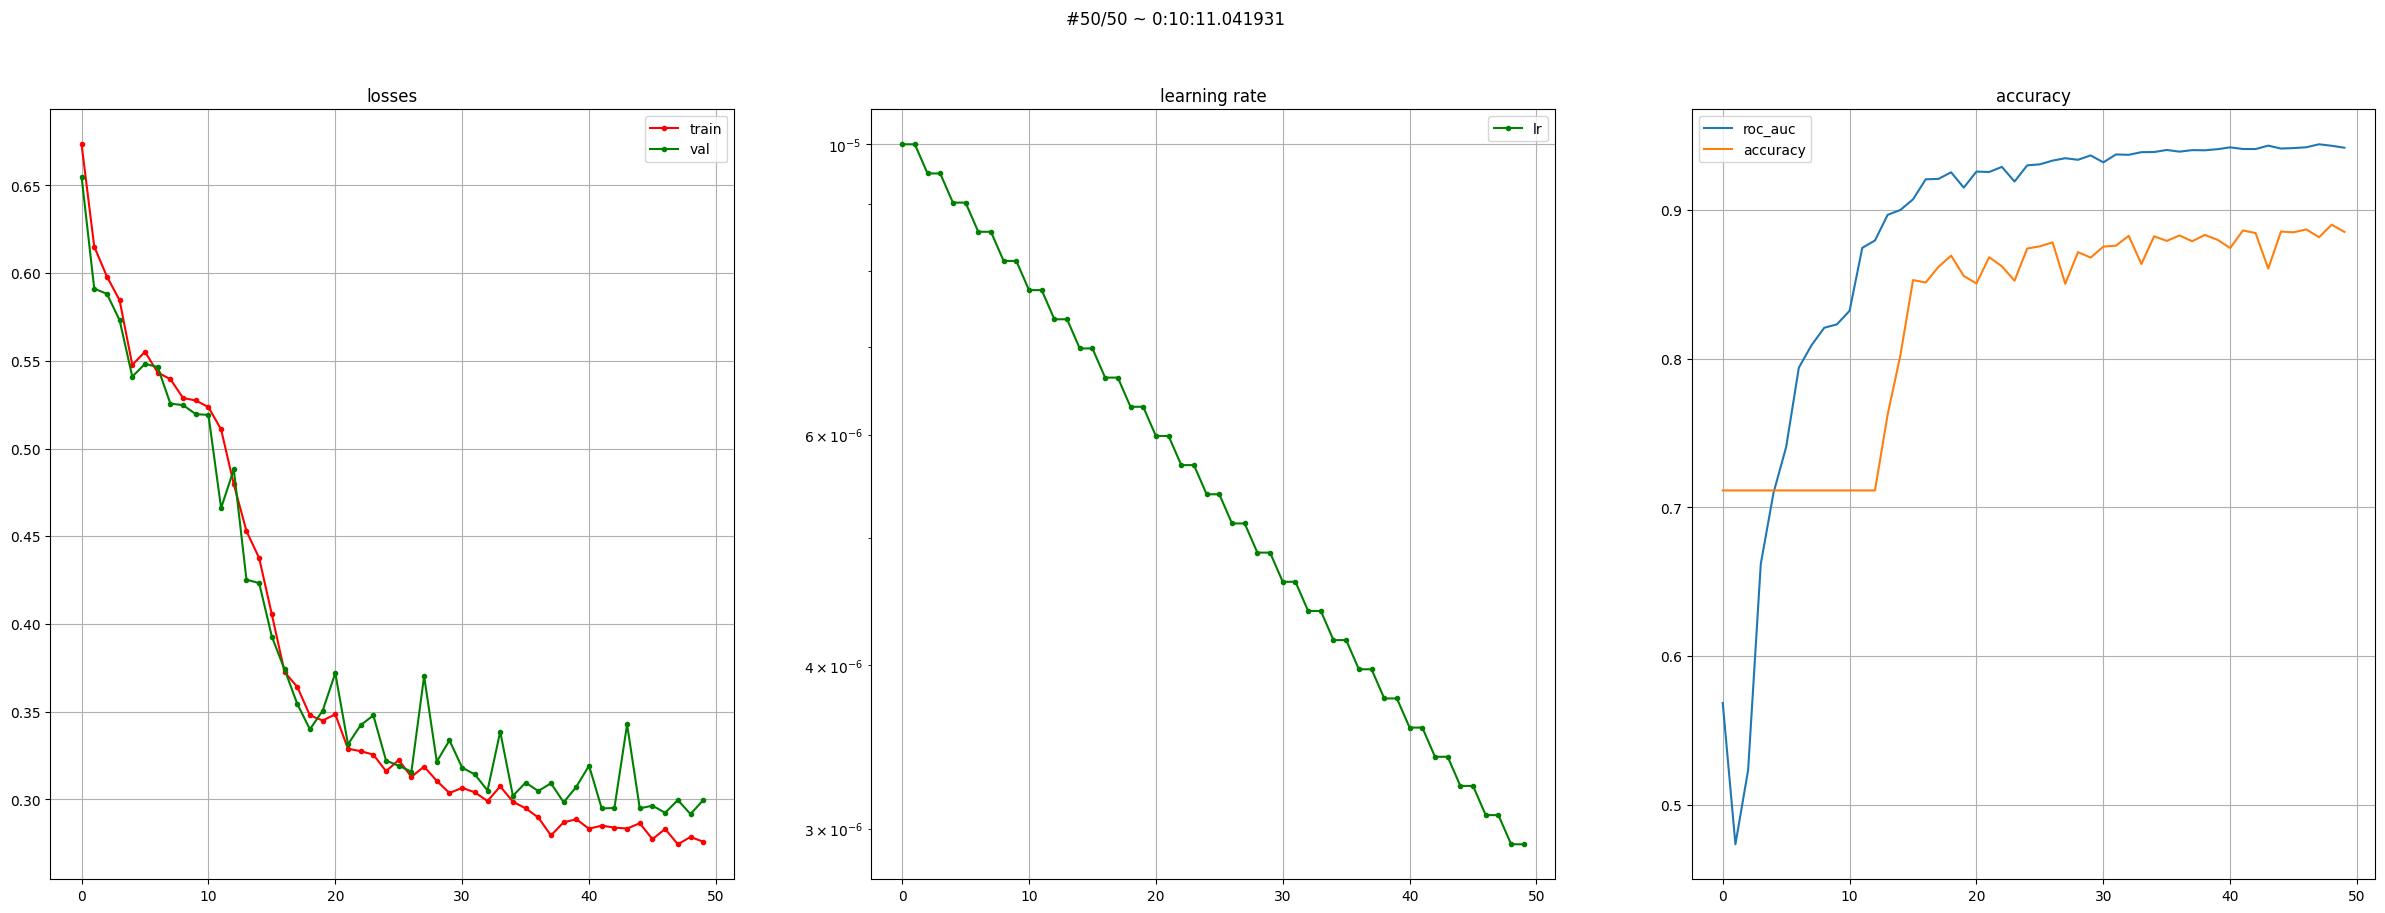

CPU times: user 13min 18s, sys: 10.6 s, total: 13min 29s
Wall time: 10min 11s


In [166]:
%%time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model=LSTMClassifier(300, 2)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95, verbose=True)

criterion = nn.BCELoss()

model, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 50,
    min_lr = None,
    val_every = 1,
    draw_every = 1,
    separate_show = False
)

In [169]:
val(model, dataloader_val, criterion)

100%|██████████| 64/64 [00:01<00:00, 35.65it/s]


(0.2995627662166953, {'roc_auc': 0.9419689703058393, 'accuracy': 0.88531816})

Попробуем энкодер из Трансформера

In [26]:
class EncoderClassifier(nn.Module):
    def __init__(self, embed_dim, num_layers, num_heads):
        super(EncoderClassifier, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
        
        self.embed.weight = nn.Parameter(
            torch.from_numpy(glove_weights).to(dtype=self.embed.weight.dtype),
            requires_grad=True,
        )
        
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, 
            nhead=num_heads, 
            batch_first=True
        )
        
        self.encoder = nn.TransformerEncoder(
            encoder_layer=self.encoder_layer,
            num_layers=num_layers,
        )
        
        self.linear = nn.Linear(embed_dim, 1)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.embed(x)
        x = self.encoder(x)
        x = self.dropout(x)
#         print(x.shape)
        x = x.max(dim=1)[0]
        out = self.linear(x)
        return nn.Sigmoid()(out)

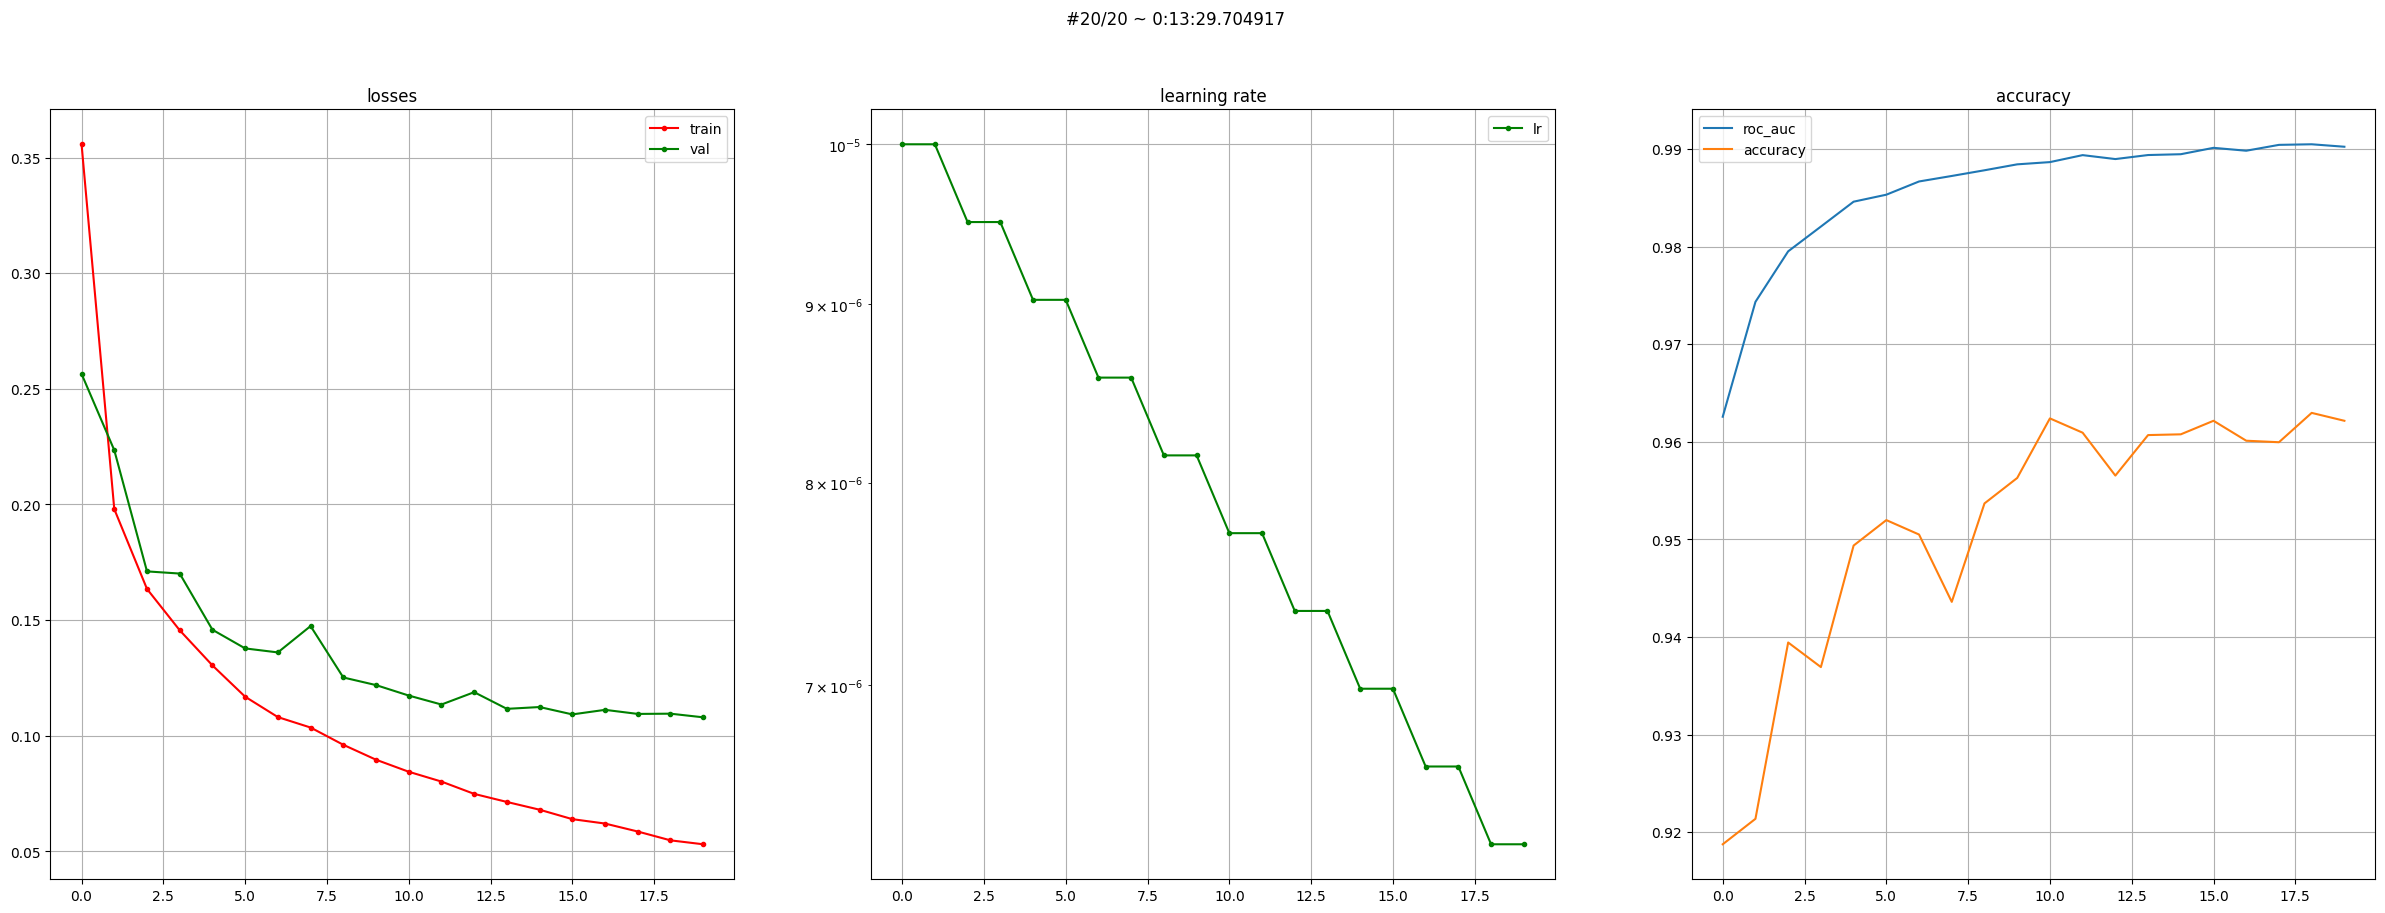

CPU times: user 13min 31s, sys: 5.9 s, total: 13min 37s
Wall time: 13min 30s


In [85]:
%%time

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

model=EncoderClassifier(300, 4, 4)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.95, verbose=True)

criterion = nn.BCELoss()

best_model_transformer, optimizer, losses = learning_loop(
    model = model,
    optimizer = optimizer,
    train_loader = dataloader_train,
    val_loader = dataloader_val,
    criterion = criterion,
    scheduler = scheduler,
    epochs = 20,
    min_lr = None,
    val_every = 1,
    draw_every = 1,
    separate_show = False
)

In [86]:
val(best_model_transformer, dataloader_val, criterion)

100%|██████████| 64/64 [00:03<00:00, 16.36it/s]


(0.10795555158983916, {'roc_auc': 0.9902370854468467, 'accuracy': 0.9621582})

Выбираем модель с трансформером так как она заметно дает лучше скор

In [87]:
class TestDataset(Dataset):
    """
    """
    def __init__(self, df):
        super().__init__()
        
        self.df = df

    def __getitem__(self, index):
        text = to_ids(self.df.text.iloc[index])
        return text

    def __len__(self):
        return self.df.__len__()

In [88]:
ds_test = TestDataset(df_test)


делаю все тоже самое для валидации чтобы проверить функцию get_prob

In [89]:
ds_test_val = TestDataset(df_val)

In [90]:
ds_test[24]

[13, 495, 4, 38, 223, 0]

In [91]:
def collate_fn_test(batch):
    local_max = max([len(j)  for j in batch])
#     print(local_max,"loccal_max")
    text_batch = torch.zeros((len(batch), local_max), dtype=torch.int)
#     label_batch = torch.zeros((len(batch)))

    for i, (text) in  enumerate(batch):
        text.extend([1]*(local_max-len(text)))
    
    for i, (text) in  enumerate(batch):
        text_batch[i,:] = torch.tensor(text)
    return text_batch

In [92]:
dataloader_test = DataLoader(
    dataset=ds_test,
    batch_size=batch_size,
    collate_fn=collate_fn_test,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [93]:
dataloader_test_val = DataLoader(
    dataset=ds_test_val,
    batch_size=batch_size,
    collate_fn=collate_fn_test,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers,
)

In [94]:
for i in dataloader_test:
    print(i)
    print(i.shape)
    break

tensor([[   56,   911,  6711,  ...,     1,     1,     1],
        [  265,    86,    25,  ...,     1,     1,     1],
        [ 1145,    11,  5366,  ...,     1,     1,     1],
        ...,
        [11933,  6552,  1110,  ...,     1,     1,     1],
        [    7,    20,  1983,  ...,     1,     1,     1],
        [  336,    23,   193,  ...,     1,     1,     1]], dtype=torch.int32)
torch.Size([64, 152])


In [95]:
torch.cuda.empty_cache()

In [96]:
def get_proba(best_model, dataloader):
    proba = []
    best_model.eval()
    with torch.no_grad():
        for text_batch in (dataloader):
#             print(text_batch)
            prob = np.array(best_model(text_batch.to(device)).cpu().squeeze())
#             print(prob)
            proba.extend(list(prob))
    return proba

In [97]:
df_test['score'] = get_proba(best_model_transformer, dataloader_test)

In [98]:
df_val['score'] =  get_proba(best_model_transformer, dataloader_test_val)

In [108]:
df_test.text.iloc[6], df_test.score.iloc[6]

('hey girl how r u hope u r well me an del r bak again long time no c give me a call sum time from lucyxx',
 0.010634615)

In [111]:
df_test.to_csv('test_spam.csv')